### LSTM(Long Short Term Memory)

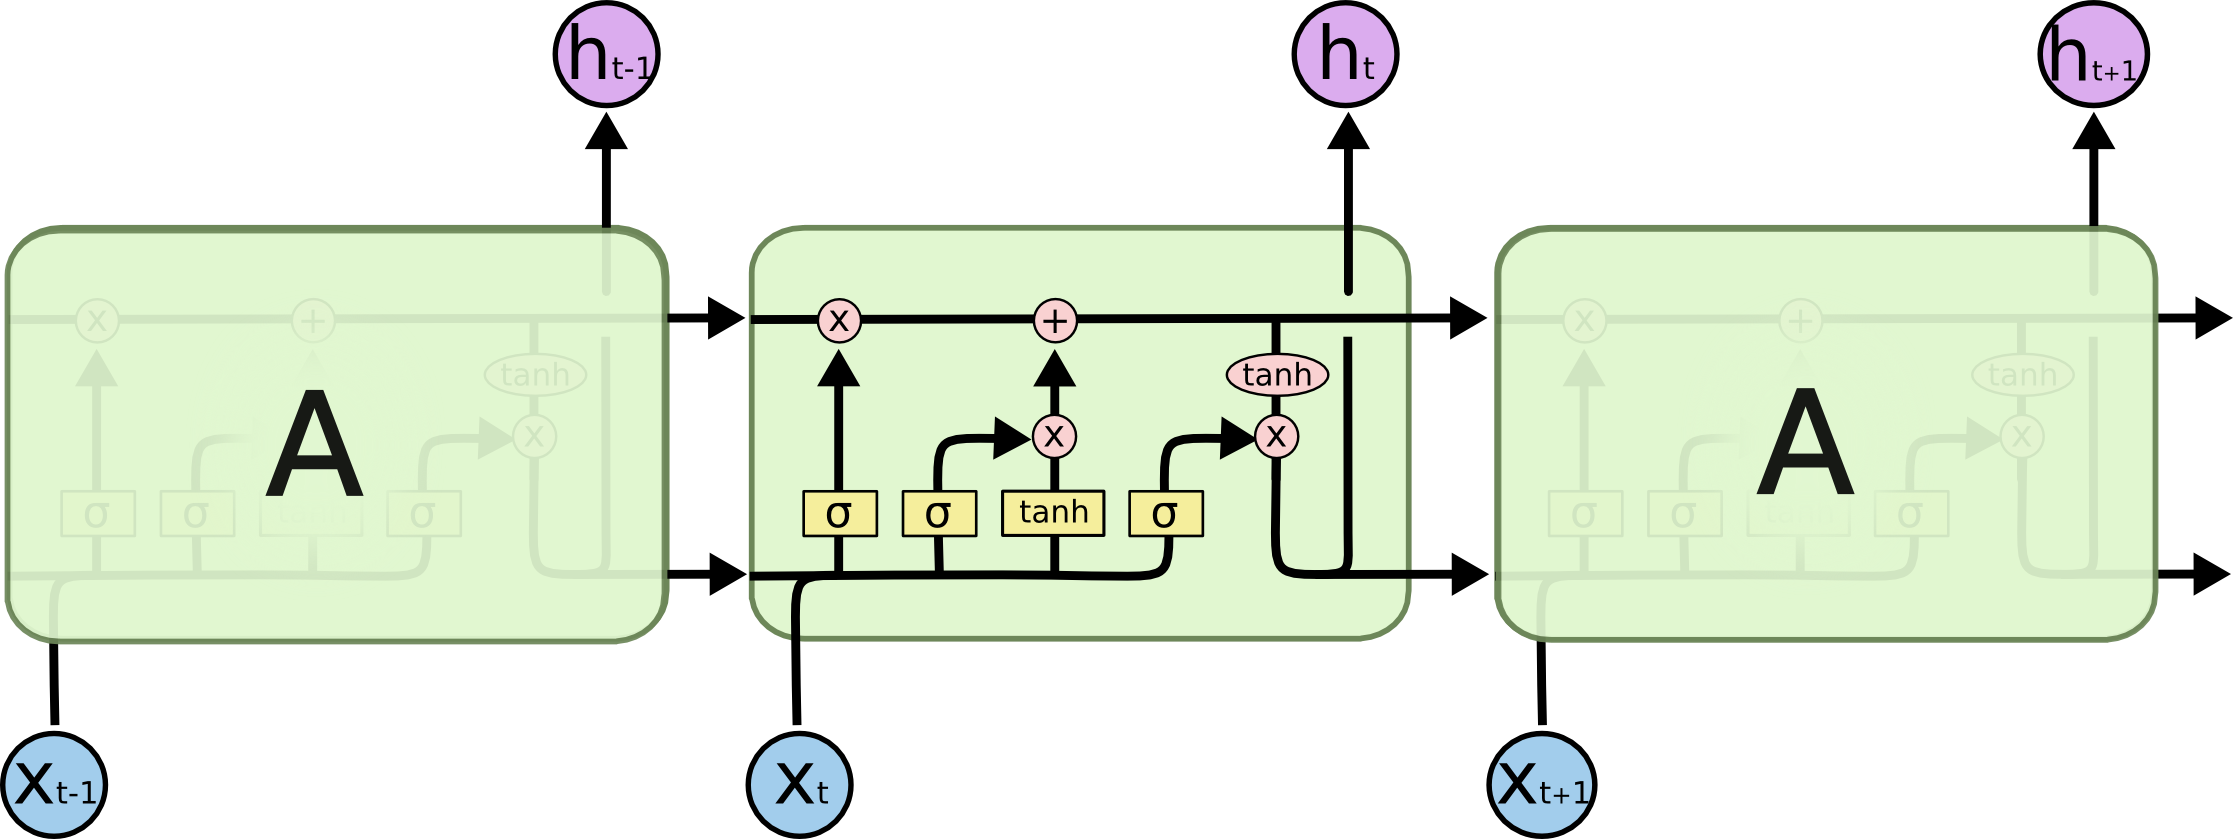

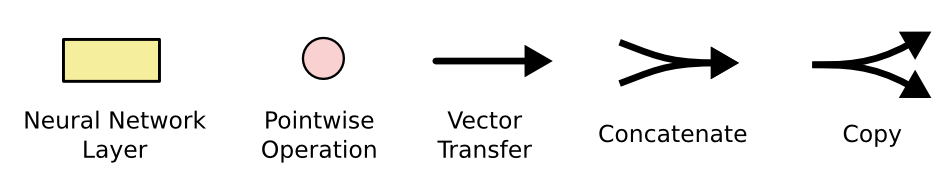

长期依赖问题(Long Term Dependencies)
eg1: The cat, which already ate a bunch of food, was full.
    |   |    |    |    |   |  |   |  |    |   |
    t0  t1   t2    t3   t4  t5  t6  t7  t8   t9  t10
eg2: The cats, which already ate a bunch of food, were full.
   |    |   |     |    |  |  |    |   |   |    |
   t0   t1  t2     t3   t4 t5 t6   t7  t8   t9   t10

### 长短期记忆网络（LSTM）
LSTM的设计灵感来源于计算机的逻辑门
* 输入门、忘记门和输出门
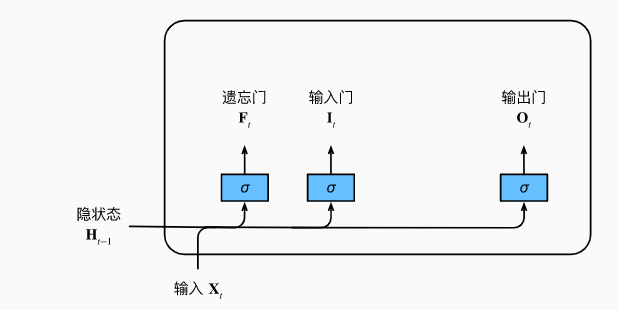、
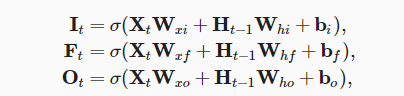
* 候选记忆元
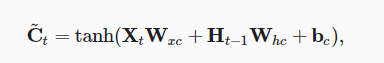
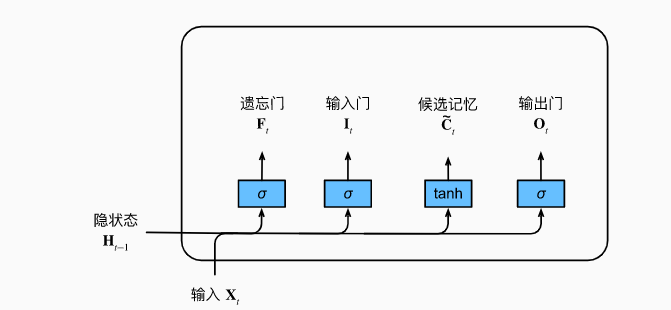
* 记忆元
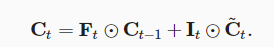
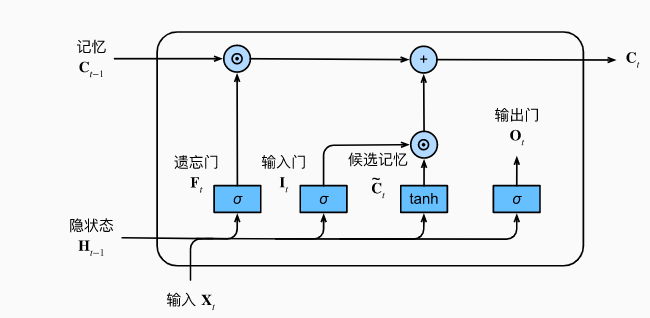
* 隐状态
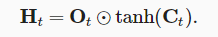
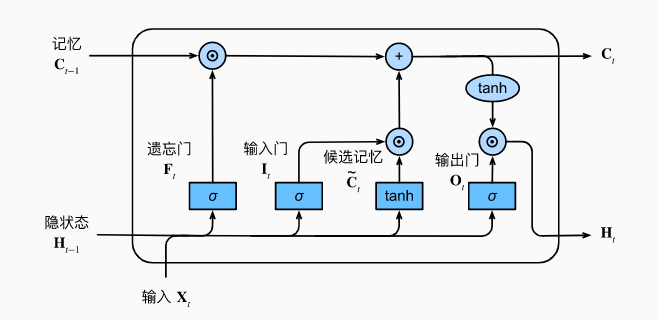

In [1]:
# 从零实现
import torch
from torch import nn
import dltools


In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = dltools.load_data_time_machine(batch_size, num_steps)

In [3]:
# 初始化模型参数
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
               normal((num_hiddens, num_hiddens)),
               torch.zeros(num_hiddens, device=device))
    
    W_xi, W_hi, b_i = three() # 输入门参数
    W_xf, W_hf, b_f = three() # 遗忘门参数
    W_xo, W_ho, b_o = three() # 输出门参数
    W_xc, W_hc, b_c = three() # 候选记忆元参数
    
    # 输出层
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
    
    for param in params:
        param.requires_grad_(True)
        
    return params

In [4]:
# 初始化隐藏状态和记忆
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
           torch.zeros((batch_size, num_hiddens), device=device))

In [5]:
# 定义lstm主体结构
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    
    outputs = []
    
    # 准备开始进行前向传播计算. 
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

In [9]:
# 试用一下.
X = torch.arange(10).reshape((2, 5))
num_hiddens = 512
net = dltools.RNNModelScratch(len(vocab), num_hiddens, dltools.try_gpu(), get_lstm_params, init_lstm_state, lstm)
state = net.begin_state(X.shape[0], dltools.try_gpu())
Y, new_state = net(X.to(dltools.try_gpu()), state)

In [10]:
Y.shape

torch.Size([10, 28])

In [12]:
new_state

(tensor([[-3.5115e-03,  2.5057e-03,  8.6320e-05,  ..., -3.2001e-03,
           9.1626e-04, -3.7068e-03],
         [ 3.9492e-04,  7.8754e-04, -3.2473e-03,  ..., -2.4838e-03,
          -3.7151e-03,  1.8050e-04]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[-0.0071,  0.0050,  0.0002,  ..., -0.0064,  0.0018, -0.0075],
         [ 0.0008,  0.0016, -0.0065,  ..., -0.0050, -0.0074,  0.0004]],
        device='cuda:0', grad_fn=<AddBackward0>))

perplexity 1.1, 25890.4 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


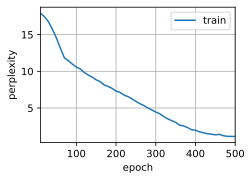

In [14]:
# 训练和预测
vocab_size, num_hiddens, device =  len(vocab), 256, dltools.try_gpu()
num_epochs, lr = 500, 1
model = dltools.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm)
dltools.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 242811.9 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


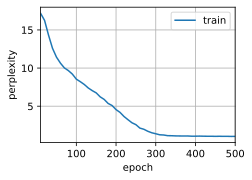

In [16]:
# pytorch简洁实现版本.
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = dltools.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
dltools.train_ch8(model, train_iter, vocab, lr, num_epochs, device)